In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Nov 18 06:49:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |   4044MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
import os
os.chdir('/content/gdrive/My Drive/Cheat Detection')
!ls

10s_resized_yolo_processed.mp4		data
cheat_detection_improved_version3.hdf5	suofang.mp4


In [27]:
# Load library
import cv2
import sys
import numpy as np
import random
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow
import re
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


# **Object Detection using YOLO v3 combined with CNN model doing cheating behavior classification.**

In [28]:

# load the class labels, stored as txt format.
LABELS = open("data/yolov3.txt").read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(666)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = "data/yolov3.weights"
configPath = "data/yolov3.cfg"

# load our YOLO object detector trained on COCO dataset
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
print("YOLO model is loaded")

YOLO model is loaded


In [29]:
# Loading the CNN model
import keras
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/gdrive/MyDrive/Cheat Detection/cheat_detection_improved_version3.hdf5',compile=False)

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pylab

def prepare_image (img):
    # convert the color from BGR to RGB then convert to PIL array
    cvt_image =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(cvt_image)

    # resize the array (image) then PIL image
    im_resized = im_pil.resize((299, 299))
    img_array = keras.preprocessing.image.img_to_array(im_resized)
    image_array_expanded = np.expand_dims(img_array, axis = 0)
    return keras.applications.mobilenet.preprocess_input(image_array_expanded)

def predict_class(model, images, show = True):
    predicted_names = []
    for student_cv_img in images:
         #student_cv_prepare_img = prepare_image(student_cv_img) 
        student_img = prepare_image(student_cv_img)
        #student_img = keras.preprocessing.image.img_to_array(student_img)                    
        #student_img = np.expand_dims(student_img, axis=0)    
        #student_img /= 255. 
        prediction = loaded_model.predict(student_img)
        index = np.argmax(prediction)
        cheat_list.sort()
        predicted_name = cheat_list[index]
        predicted_names.append(predicted_name)
        #print(predicted_names[0])
        #pylab.imshow(student_img[0])
        #pylab.show()
    return predicted_names

In [30]:
cheat_video = cv2.VideoCapture("/content/gdrive/MyDrive/Cheat Detection/suofang.mp4")
frame_array = [] # store the frames from the video
output_frames = []
i = 1
while(cheat_video.isOpened()):
  ret, frame = cheat_video.read()
  if ret == False:
    break
  #frame = cv2.resize(frame, (299, 299))
  frame_array.append(frame)
cheat_video.release()
cv2.destroyAllWindows() 

thre_confidence = 0.5
thre_nms = 0.3

i = 0
last_image = frame_array[0]

passes=[]
peeps=[]


for image in frame_array:
  if i % 16 == 0:

    pass_ini = 0
    peep_ini = 0

    (H, W) = image.shape[:2]

    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()

    # initialize our lists of detected bounding boxes, confidences, and class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > thre_confidence:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, thre_confidence,  thre_nms)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            if classIDs[i] == 0:
                # extract the bounding box coordinates
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                if x <= 0:
                  x = 1
                if y <= 0:
                  y = 1
                if w <= 0:
                  w = 1
                if h <= 0:
                  h = 1
                person = image[y:y+h, x:x+w]
                cheat_list=['not_cheating','passing_notes','peep']
                images = []
                images.append(person)
                
                predicted_names = predict_class(loaded_model, images, True)
                if predicted_names[0] == "passing_notes" or predicted_names[0] == "peep":
                    # draw a bounding box rectangle and label on the image
                    text = predicted_names[0]
                    if predicted_names[0] == "passing_notes":
                      pass_ini= pass_ini+1
                     
                      cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,255), 2, lineType=cv2.LINE_AA)
                      cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, lineType=cv2.LINE_AA)
                    else:
                      peep_ini=peep_ini+1
                      
                      cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), 2, lineType=cv2.LINE_AA)
                      cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2, lineType=cv2.LINE_AA)
    output_frames.append(image)
  else:
    last_image = output_frames[len(output_frames) - 1]
    output_frames.append(last_image)
  i = i + 1
  print("\nDone: " + str(len(output_frames)) + " / " + str(len(frame_array)) + " frames")
  print("pass %d times, peep %d times."%(pass_ini,peep_ini))

  passes.append(pass_ini)
  peeps.append(peep_ini)
  print(passes)
  print(peeps)


Done: 1 / 307 frames
pass 3 times, peep 9 times.
[3]
[9]

Done: 2 / 307 frames
pass 3 times, peep 9 times.
[3, 3]
[9, 9]

Done: 3 / 307 frames
pass 3 times, peep 9 times.
[3, 3, 3]
[9, 9, 9]

Done: 4 / 307 frames
pass 3 times, peep 9 times.
[3, 3, 3, 3]
[9, 9, 9, 9]

Done: 5 / 307 frames
pass 1 times, peep 8 times.
[3, 3, 3, 3, 1]
[9, 9, 9, 9, 8]

Done: 6 / 307 frames
pass 1 times, peep 8 times.
[3, 3, 3, 3, 1, 1]
[9, 9, 9, 9, 8, 8]

Done: 7 / 307 frames
pass 0 times, peep 7 times.
[3, 3, 3, 3, 1, 1, 0]
[9, 9, 9, 9, 8, 8, 7]

Done: 8 / 307 frames
pass 0 times, peep 7 times.
[3, 3, 3, 3, 1, 1, 0, 0]
[9, 9, 9, 9, 8, 8, 7, 7]

Done: 9 / 307 frames
pass 0 times, peep 7 times.
[3, 3, 3, 3, 1, 1, 0, 0, 0]
[9, 9, 9, 9, 8, 8, 7, 7, 7]

Done: 10 / 307 frames
pass 0 times, peep 7 times.
[3, 3, 3, 3, 1, 1, 0, 0, 0, 0]
[9, 9, 9, 9, 8, 8, 7, 7, 7, 7]

Done: 11 / 307 frames
pass 0 times, peep 7 times.
[3, 3, 3, 3, 1, 1, 0, 0, 0, 0, 0]
[9, 9, 9, 9, 8, 8, 7, 7, 7, 7, 7]

Done: 12 / 307 frames
pass 0 

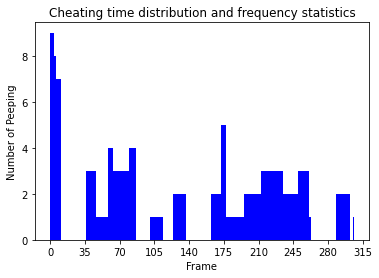

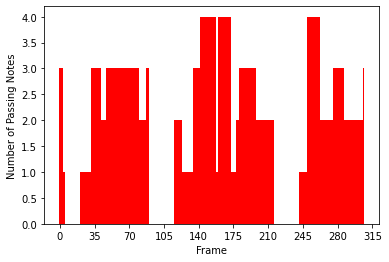

In [94]:
import matplotlib.pyplot as plt
import numpy as np
 
#添加图形属性
plt.xlabel('Frame')
plt.ylabel('Number of Peeping')
plt.title('Cheating time distribution and frequency statistics')
 
y = peeps  #这个是y轴的数据
first_bar = plt.bar(range(len(y)), y, color='blue')  #初版柱形图，x轴0-9，y轴是列表y的数据，颜色是蓝色
 
#开始绘制x轴的数据
index = [0, 35, 70, 105, 140, 175, 210, 245, 280, 315]
name_list = ['0', '35', '70', '105', '140', '175', '210', '245', '280', '315']  #x轴标签
plt.xticks(index, name_list) #绘制x轴的标签
 
#柱形图顶端数值显示
for data in first_bar:
    y = data.get_height()
    x = data.get_x()
    #plt.text(x+0.15, y , str(y), va='bottom')  #0.15为偏移值，可以自己调整，正好在柱形图顶部正中
 
#图片的显示及存储
plt.savefig('Peeping.jpg')
plt.show()   #这个是图片显示
#log = datetime.datetime.now().strftime('%Y-%m-%d')
#plt.savefig('./logging/%s_all_a.jpg' % log)   #图片的存储
#plt.close()   #关闭matplotlib



plt.xlabel('Frame')
plt.ylabel('Number of Passing Notes')

y2 = passes 
first_bar = plt.bar(range(len(y2)), y2, color='red')  #初版柱形图，x轴0-9，y轴是列表y的数据，颜色是蓝色

index = [0, 35, 70, 105, 140, 175, 210, 245, 280, 315]
name_list = ['0', '35', '70', '105', '140', '175', '210', '245', '280', '315'] 
plt.xticks(index, name_list) 
 

for data in first_bar:
    y2 = data.get_height()
    x = data.get_x()
plt.savefig('Passing Notes.jpg')
plt.show()   


In [96]:
result = cv2.VideoWriter('10s_resized_yolo_processed.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 24, (1920,1080))
for i in range(len(output_frames)):
  result.write(output_frames[i])
result.release()

# **Below is the CNN model.**

In [ ]:
from __future__ import division
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np
import os

def create_model():
  inception = InceptionV3(input_shape=(299,299,3),include_top=False,weights='imagenet')
  inception.trainable=False
  base = inception.output
  x = GlobalAveragePooling2D(name='GlobalPooling')(base)
  x = Dense(128,activation='relu',name='Dense1')(x)
  x = Dropout(0.2,name='Dropout1')(x)
  x = Dense(128,activation='relu',name='Dense2')(x)
  x = Dropout(0.2,name='Dropout2')(x)
  predictions = Dense(3, activation='softmax',name='output')(x)
  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

In [ ]:
K.clear_session()
batch_size=128
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = '/content/gdrive/My Drive/Cheat Detection/training_dataset'
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', subset='training')
validation_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', subset='validation')

In [ ]:
checkpointer = ModelCheckpoint(filepath='best_model_class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')
history_class = model.fit(train_generator,
              steps_per_epoch = train_generator.samples // batch_size,
              validation_data=validation_generator,
              validation_steps=validation_generator.samples // batch_size,
              epochs=30,
              verbose=1,
              callbacks=[csv_logger, checkpointer])

model.save('cheat_detection_improved_version2.hdf5')

In [ ]:
# Loading the model
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/gdrive/My Drive/Cheat Detection/cheat_detection_improved_version2.hdf5',compile=False)

In [ ]:
# labels of 101 classes of food
cheat_list=['not_cheating','passing_notes','peep']

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def predict_class(model, images, show = True):
  for student_img in images:
    student_img = image.load_img(student_img, target_size=(299, 299))
    student_img = image.img_to_array(student_img)                    
    student_img = np.expand_dims(student_img, axis=0)    
    student_img /= 255. 
    prediction = loaded_model.predict(student_img)
    index = np.argmax(prediction)
    cheat_list.sort()
    predicted_name = cheat_list[index]
    print(predicted_name)

In [ ]:
# Test
images = []
images.append('/content/gdrive/MyDrive/Cheat Detection/training_dataset/passing_notes/2_107.JPG')
images.append('/content/gdrive/MyDrive/Cheat Detection/training_dataset/passing_notes/2_110.JPG')
images.append('/content/gdrive/MyDrive/Cheat Detection/training_dataset/not_cheating/1_13.JPG')
images.append('/content/gdrive/MyDrive/Cheat Detection/training_dataset/not_cheating/1_2.JPG')
images.append('/content/gdrive/MyDrive/Cheat Detection/training_dataset/peeping/3_49.JPG')
predict_class(loaded_model, images, True)
for i in range(len(images)):
  cheat_test_image = cv2.imread(images[i])
  cv2_imshow(cheat_test_image)

# **Below is the pose estimation shown as skeleton.**

In [ ]:
ptsLbl      = ['Nose',          # 0
               'Neck',          # 1
               'R:Shoulder',    # 2
               'R:Elbow',       # 3
               'R:Wrist',       # 4
               'L:Shoulder',    # 5
               'L:Elbow',       # 6
               'L:Wrist',       # 7
               'R:Hip',         # 8
               'R:Knee',        # 9
               'R:Ankle',       # 10
               'L:Hip',         # 11
               'L:Knee',        # 12
               'L:Ankle',       # 13
               'R:Eye',         # 14
               'L:Eye',         # 15
               'R:Ear',         # 16
               'L:Ear']         # 17
                                # 18 (background)

links       = [[1,2],       # Neck to R:Shoulder
               [1,5],       # Neck to L:Shoulder
               [2,3],       # R:Shoulder to R:Elbow
               [3,4],       # R:Elbow to R:Wrist
               [5,6],       # L:Shoulder to L:Elbow 
               [6,7],       # L:Elbow to L:Wrist
               [1,8],       # Neck to R:Hip
               [8,9],       # R:Hip to R:Knee
               [9,10],      # R:Knee to R:Ankle
               [1,11],      # Neck to L:Hip
               [11,12],     # L:Hip to L:Knee
               [12,13],     # L:Knee to L:Ankle
               [1,0],       # Neck to Nose
               [0,14],      # Nose to R:Eye
               [14,16],     # R:Eye to L:Ear
               [0,15],      # Nose to L:Eye
               [15,17],     # L:Eye to L:Ear
               [2,17],      # R:Shoulder to L:Ear
               [5,16]]      # L:Shoulder to R:Ear

                            # In total there are 19 pairs in 'links'


                            # Pairs of channel that corresponds to the
                            # pairs in 'links'                            
                            # For example, the PAFs of link [1,2] are
                            # located at channel [31,32] 
pafCh       = [[31,32],     # Neck to R:Shoulder
               [39,40],     # Neck to L:Shoulder
               [33,34],     # R:Shoulder to R:Elbow
               [35,36],     # R:Elbow to R:Wrist
               [41,42],     # L:Shoulder to L:Elbow 
               [43,44],     # L:Elbow to L:Wrist
               [19,20],     # Neck to R:Hip
               [21,22],     # R:Hip to R:Knee
               [23,24],     # R:Knee to R:Ankle
               [25,26],     # Neck to L:Hip
               [27,28],     # L:Hip to L:Knee
               [29,30],     # L:Knee to L:Ankle
               [47,48],     # Neck to Nose
               [49,50],     # Nose to R:Eye
               [53,54],     # R:Eye to L:Ear
               [51,52],     # Nose to L:Eye
               [55,56],     # L:Eye to L:Ear
               [37,38],     # R:Shoulder to L:Ear
               [45,46]]     # L:Shoulder to R:Ear

colours     = [[0,100,255],
               [0,100,255],
               [0,255,255],
               [0,100,255],
               [0,255,255],
               [0,100,255],
               [0,255,0],
               [255,200,100],
               [255,0,255],
               [0,255,0],
               [255,200,100],
               [255,0,255],
               [0,0,255],
               [255,0,0],
               [200,200,0],
               [255,0,0],
               [200,200,0],
               [0,0,0]]

ptColours   = [[0,100,255],     # 0
               [0,100,255],     # 1
               [0,100,255],     # 2
               [0,255,0],       # 3
               [0,255,255],     # 4
               [0,100,255],     # 5
               [0,255,0],       # 6
               [0,255,255],     # 7
               [255,0,255],     # 8
               [0,0,255],       # 9
               [255,0,0],       # 10
               [255,0,255],     # 11
               [0,0,255],       # 12
               [255,0,0],       # 13
               [0,0,0],         # 14
               [0,0,0],         # 15
               [200,200,0],     # 16
               [200,200,0]]     # 17

print(ptsLbl)

In [ ]:
def searchPts(prMap,
              prThres=0.1):
    blur        = cv2.GaussianBlur(prMap,
                                   (3,3),
                                   0,           # Set SigmaX to 0
                                   0)           # Set SigmaY to 0, so that the SigmaX and SigmaY
                                                # are computed from kernel size
    mask        = np.uint8(blur > prThres)
    pts         = []
    
                                                # find all the blobs in the mask
    if cv2.__version__ == '3.4.2':
        (_,ctrs,_)  = cv2.findContours(mask,
                                       cv2.RETR_TREE,           # contour retrieval modes
                                       cv2.CHAIN_APPROX_SIMPLE) # contounr approximation methods
    else:
                                                # for opencv version 4.0 and above
        (ctrs,_)    = cv2.findContours(mask,
                                       cv2.RETR_TREE,
                                       cv2.CHAIN_APPROX_SIMPLE)
        
                                                # Go through each blob and find the maximum point
                                                # in the blob
    for ctr in ctrs:
        blobs       = np.zeros(mask.shape)
        blobs       = cv2.fillConvexPoly(blobs,
                                         ctr,
                                         1)
        blob        = blur*blobs
        (_,maxVal,
         _,maxLoc)  = cv2.minMaxLoc(blob)       # The output of 'maxLoc' is (x,y)
        pts.append(maxLoc + (prMap[maxLoc[1],maxLoc[0]],))
                                                # The output of 'pts' is a list
                                                # for each item in the list is a tuple of
                                                # (x,y,probability)
    return (pts,mask)

print(searchPts)

In [ ]:
def getAllPoints(cfMaps,
                 imgWidth,
                 imgHeight,
                 cfThres=0.1,
                 numOfKeyPts=18):
    ptGrp       = []
    ptList      = np.zeros((0,3))
    idx         = 0
    
    for keyPts in range(numOfKeyPts):
        prMap       = cfMaps[0,keyPts,:,:]
        prMap       = cv2.resize(prMap,
                                 (imgWidth,imgHeight))
        (pts,_)     = searchPts(prMap,
                                prThres=cfThres)
        ptWithId    = []
        for pt in range(len(pts)):
            ptWithId.append(pts[pt] + (idx,))
            ptList  = np.vstack([ptList,
                                 pts[pt]])
            idx     = idx+1
            
        ptGrp.append(ptWithId)
    return (ptGrp,ptList)

print(getAllPoints)

In [ ]:
def getAllLinks(pafs,
                links,
                linkCh,
                ptGrp,
                imgSize,
                numOfPtsForLine=10,
                pafThres=0.1,
                cfThres=0.7):

    linksWithPairs  = []
    linksNoPairs    = []
    (H,W)           = imgSize

    for l in range(len(linkCh)):
                                            # Extract the two matrix for 
                                            # a single part affinity field that
                                            # involved in a link
        paf0        = output[0,pafCh[l][0],:,:]
        paf1        = output[0,pafCh[l][1],:,:]
        paf0        = cv2.resize(paf0,      # resize the matrix to the image
                                 (W,H))     # original size
        paf1        = cv2.resize(paf1,
                                 (W,H))
        
        linkPt0     = links[l][0]           # The first point in the link
        linkPt1     = links[l][1]           # The second point in the link
        
        pts0        = ptGrp[linkPt0]        # Get all the points identified as the first point in the link
        pts1        = ptGrp[linkPt1]        # Get all the points identified as the second point in the link
        
        numOfPts0   = len(pts0)
        numOfPts1   = len(pts1)
        
        if (numOfPts0 != 0 and numOfPts1 !=0):
            inPairs     = np.zeros((0,3))
            
            for i in range(numOfPts0):
                maxScore    = -1
                maxj        = -1
                linkLocated = 0
                
                for j in range(numOfPts1):
                                                        # e.g. pts0[i] --> (600,363,0.85,2)
                                                        # e.g. pts1[j] --> (230,242,0.77,5)
                    dij         = np.subtract(pts1[j][:2],pts0[i][:2])
                                                        # e.g. dij --> [-370,-121]
                    norm        = np.linalg.norm(dij)
                                                        # e.g. norm --> 389.28
                    if norm:
                        dij     = dij/norm              # e.g. dij --> [-0.95,-0.31]
                                                        # a unit vector
                                                        
                                                        # Generate 10 points, starting from,
                                                        # e.g. (600,363) to (230,242)
                                                        # Note: the notation for each point is (x,y)
                                                        # the output is a list that has 10 tuples of size 2
                    linePts     = list(zip(np.linspace(pts0[i][0],
                                                       pts1[j][0],
                                                       num=numOfPtsForLine),
                                           np.linspace(pts0[i][1],
                                                       pts1[j][1],
                                                       num=numOfPtsForLine)))        
                    pafVectors  = []
                    
                                                        # Get the vector (a 2 values tuple) from
                                                        # PAF for each point in the line
                    for k in range(len(linePts)):                            
                        vector  = [paf0[int(round(linePts[k][1])),
                                        int(round(linePts[k][0]))],
                                   paf1[int(round(linePts[k][1])),
                                        int(round(linePts[k][0]))]]
                        pafVectors.append(vector)       # pafVectors is a list of 10 tuple,
                                                        # each tuple is a size of 2
                    
                    pafScore    = np.dot(pafVectors,dij)    # perform dot product between a vector and dij, for all vectors
                                                            # This is to get the magnitude of each vector in the
                                                            # direction of the unit vector
                    avgPafScore = sum(pafScore)/len(pafScore)  
                    ptsBydThres = np.where(pafScore > pafThres)     # points with score that exceeds 'pafThres'
                                                                    # the output is a tuple, with a numpy array inside
                    ptsBydThres = ptsBydThres[0]                    # this is required to extract the numpy array 
                    
                    if (len(ptsBydThres)/numOfPtsForLine) > cfThres:
                        if avgPafScore > maxScore:
                            maxj        = j
                            maxScore    = avgPafScore
                            linkLocated = 1
                if linkLocated:
                    inPairs     = np.append(inPairs,
                                            [[pts0[i][3],pts1[maxj][3],maxScore]],
                                            axis=0)
            if inPairs.shape[0] == 0:           # When there is no pair in this link
                linksNoPairs.append(l)
                linksWithPairs.append([])
            else:
                linksWithPairs.append(inPairs)
        else:
            linksNoPairs.append(l)
            linksWithPairs.append([])
            
    return (linksWithPairs,linksNoPairs)

print(getAllLinks)

In [ ]:
def getPersons(linksWithPairs,
               linksNoPairs,
               selLinks,                # sometimes we dont need all the links, just the selected links
               ptList):
    persons         = -1*np.ones((0,19))# each row in this matrix will represent a person
                                        # a person is denoted by 18 possible points (columns)
                                        # and the last column is to the total score for the person
                                        
                                        # the minus 1 is needed to make sure, when there is no value
                                        # filled in a cell, the value of the cell is -1, instead of 1
    for k in range(len(selLinks)):
        if k not in linksNoPairs:
                                        # we start the identification of the belonging of links
                                        # to a person by going through link by link
                                        # For a particular link, say from Neck to Right shoulder,
                                        # we look at all the links of this type
            jointsOf0   = linksWithPairs[k][:,0]    # we take all the first joints (the numbers identified with the joints) in this type of link
            jointsOf1   = linksWithPairs[k][:,1]    # we take all the second joints (the numbers identified with the joints) in this type of link
            (jointIdxOf0,
             jointIdxOf1)=np.array(selLinks[k])

            for i in range(len(jointsOf0)):
                                        # We go through all the first joints in that type of link
                exist   = 0
                personId= -1
                
                for j in range(len(persons)):
                                        # For each first joint, we search through the persons we have
                    if persons[j][jointIdxOf0]  == jointsOf0[i]:
                                        # If the joint is already identified with a person
                                        # we identify the id of the person, and inform its
                                        # existence
                        personId= j
                        exist   = 1
                        break
                        
                if exist:
                                    # If the joint is already with a person,
                                    # add the second joint of that link to the person
                    persons[personId][jointIdxOf1]  = jointsOf1[i]
                                    # Get the score for the joint 
                                    # and get the score for that link, sum them
                                    # with the score in the last column for that person
                    ptScoreOf1                      = ptList[jointsOf1[i].astype(int),2]
                    linkScore                       = linksWithPairs[k][i][2]
                    persons[personId][-1]           +=ptScoreOf1 + linkScore

                else:
                                    # If that joint is not with any person,
                                    # add the first joint to the person,
                                    # add the second joint to the person,
                                    # get the score for both joints, get the link score,
                                    # sum the three scores and put to the last column
                    newPerson       = -1*np.ones(19)
                    newPerson[jointIdxOf0]  = jointsOf0[i]
                    newPerson[jointIdxOf1]  = jointsOf1[i]
                    
                    ptScoreOf0              = ptList[jointsOf0[i].astype(int),2]
                    ptScoreOf1              = ptList[jointsOf1[i].astype(int),2]
                    linkScore               = linksWithPairs[k][i][2]
                    newPerson[-1]           = ptScoreOf0+ptScoreOf1+linkScore
                    
                    persons                 = np.vstack([persons,newPerson])
    return persons

print(getPersons)

In [ ]:
def drawSkeleton(image,
                 selLinks,
                 persons,
                 ptList,
                 lineColours,
                 ptColours,
                 pltThres=4):
    
    for l in range(len(persons)):
        if persons[l,-1] > pltThres:
            for i in range(len(selLinks)):
                link    = persons[l,np.array(selLinks[i])]
                link    = link.astype(int)
                
                if -1 in link:
                    continue
                
                pt0     = np.int32(ptList[link[0],:2])
                pt1     = np.int32(ptList[link[1],:2])
                
                cv2.line(image,
                         (pt0[0],pt0[1]),
                         (pt1[0],pt1[1]),
                         lineColours[i],
                         3,
                         cv2.LINE_AA)
            
            pts     = persons[l]
            for j in range(len(pts)-1):
                if pts[j] == -1:
                    continue
                #print(pts[j])
                pt  = np.int32(ptList[int(pts[j]),:2])
                
                cv2.circle(image,
                           (pt[0],pt[1]),
                           5,
                           [255,255,255],
                           -1,
                           cv2.LINE_AA)
                cv2.circle(image,
                           (pt[0],pt[1]),
                           5,
                           ptColours[j],
                           1,
                           cv2.LINE_AA)
    return image

print(drawSkeleton)

In [ ]:
print(cv2.__version__)

In [ ]:
timeBegin   = time.time()                                                       # Step 1

img         = cv2.imread("/content/gdrive/My Drive/Cheat Detection/data/captured-2.JPG")      # Step 2
                                                                                # Step 3
prototxt    = "/content/gdrive/My Drive/Cheat Detection/data/pose_deploy_linevec.prototxt"
caffemodel  = "/content/gdrive/My Drive/Cheat Detection/data/pose_iter_440000.caffemodel"

net         = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)
                                                                                # Step 4
(H,W,_)     = img.shape
iptH        = 360
iptW        = int((iptH/H)*W)
blob        = cv2.dnn.blobFromImage(image=img,
                                    scalefactor=1.0/255,
                                    size=(iptW,iptH),
                                    mean=(0,0,0),
                                    swapRB=False,
                                    crop=False)


                                                                                # Step 5
net.setInput(blob)
output      = net.forward()

print("Forward duration: %.2fs" % (time.time()-timeBegin))                      # Step 6

In [ ]:
# Type your code below
from google.colab.patches import cv2_imshow
(ptGrp,ptList) = getAllPoints(cfMaps=output, imgWidth=W, imgHeight=H)
(linksWithPairs, linksNoPairs) = getAllLinks(output, links, pafCh, ptGrp, (H,W))
persons = getPersons(linksWithPairs, linksNoPairs, links[0:6], ptList)
sklImg = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
skel = drawSkeleton(sklImg, links[0:6], persons, ptList, colours, ptColours)
cv2_imshow(sklImg)

In [ ]:
print(len(persons))

In [ ]:
test_video = cv2.VideoCapture('/content/gdrive/My Drive/Cheat Detection/data/clip222.mp4')
frame_array = [] # store the processed frames then convert them into video
i = 1
while(test_video.isOpened()):
  ret, frame = test_video.read()
  if ret == False:
    break
  frame_array.append(frame)

test_video.release()
cv2.destroyAllWindows() 

In [ ]:
img_array = []

for img in frame_array:
  prototxt    = "/content/gdrive/My Drive/Cheat Detection/data/pose_deploy_linevec.prototxt"
  caffemodel  = "/content/gdrive/My Drive/Cheat Detection/data/pose_iter_440000.caffemodel"
  net         = cv2.dnn.readNetFromCaffe(prototxt, caffemodel)                                                                                 # Step 4
  (H,W,_)     = img.shape
  iptH        = 360
  iptW        = int((iptH/H)*W)
  blob        = cv2.dnn.blobFromImage(image=img,scalefactor=1.0/255,size=(iptW,iptH),mean=(0,0,0),swapRB=False,crop=False)                                                                              # Step 5
  net.setInput(blob)
  output      = net.forward()
  (ptGrp,ptList) = getAllPoints(cfMaps=output, imgWidth=W, imgHeight=H)
  (linksWithPairs, linksNoPairs) = getAllLinks(output, links, pafCh, ptGrp, (H,W))
  persons = getPersons(linksWithPairs, linksNoPairs, links[0:6], ptList)
  sklImg = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
  skel = drawSkeleton(sklImg, links[0:6], persons, ptList, colours, ptColours)
  img_array.append(sklImg)
  print("Done: "+str(len(img_array))+" frames")

In [ ]:
result = cv2.VideoWriter('clip222_processed.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 15, (1920,1080))
for i in range(len(img_array)):
  result.write(img_array[i])
result.release()

# **Below is the YOLO v3 model.**

In [ ]:
# load the class labels
LABELS = open("data/yolov3.txt").read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(666)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = "data/yolov3.weights"
configPath = "data/yolov3.cfg"

# load our YOLO object detector trained on COCO dataset
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
print("YOLO model is loaded")

In [ ]:
image_file_name = "data/captured-3.JPG"
# image_file_name = "data/person.jpg"

# 原: 0.5 0.2
thre_confidence = 0.5
thre_nms = 0.2

# load our input image and grab its spatial dimensions
image = cv2.imread(image_file_name)

(H, W) = image.shape[:2]

# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

print("YOLO took %.4f seconds" % (end - start))

print(len(layerOutputs), layerOutputs[0].shape)

# list of 3 arrays, each array has a dimension of N * 85
# 3: three scales to perform object detection
# N: detected N boxes
# 85: (x,y,w,h), object score, confidence score for 80 classes (we are performing 80 categories of object detections)

In [ ]:
# initialize our lists of detected bounding boxes, confidences, and class IDs, respectively
boxes = []
confidences = []
classIDs = []

# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        # extract the class ID and confidence (i.e., probability) of
        # the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if confidence > thre_confidence:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

In [ ]:
print(classIDs)

In [ ]:
# apply non-maxima suppression to suppress weak, overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, thre_confidence,  thre_nms)

# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
      if LABELS[classIDs[i]] == "person":
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # draw a bounding box rectangle and label on the image
        
        color = [int(c) for c in COLORS[classIDs[i]]]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 1, lineType=cv2.LINE_AA)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
            0.5, color, 1, lineType=cv2.LINE_AA)
        
cv2_imshow(image)

In [ ]:
cheat_video = cv2.VideoCapture("data/suofang40s.mp4")
frame_array = [] # store the frames from the video
output_frames = []
i = 1
while(cheat_video.isOpened()):
  ret, frame = cheat_video.read()
  if ret == False:
    break
  #frame = cv2.resize(frame, (299, 299))
  frame_array.append(frame)
cheat_video.release()
cv2.destroyAllWindows() 

thre_confidence = 0.5
thre_nms = 0.3

i = 0
last_image = frame_array[0]

for image in frame_array:
  if i % 16 == 0:
    (H, W) = image.shape[:2]

    # determine only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # construct a blob from the input image and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes and
    # associated probabilities
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()

    # initialize our lists of detected bounding boxes, confidences, and class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []

    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability) of
            # the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > thre_confidence:
                # scale the bounding box coordinates back relative to the
                # size of the image, keeping in mind that YOLO actually
                # returns the center (x, y)-coordinates of the bounding
                # box followed by the boxes' width and height
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # use the center (x, y)-coordinates to derive the top and
                # and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # update our list of bounding box coordinates, confidences,
                # and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, thre_confidence,  thre_nms)

    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            if classIDs[i] == 0:
                # extract the bounding box coordinates
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])
                
                print(str(boxes[i][0])+" "+str(boxes[i][1])+" "+str(boxes[i][1])+" "+str(boxes[i][2]))
                #cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,255), 2, lineType=cv2.LINE_AA)
                #cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2, lineType=cv2.LINE_AA)
                
    output_frames.append(image)
  else:
    #last_image = output_frames[len(output_frames) - 1]
    output_frames.append(image)
  i = i + 1
  print("Done: " + str(len(output_frames)) + " / " + str(len(frame_array)) + " frames")

In [ ]:
result = cv2.VideoWriter('cheat_detection_resized_yolo_processed_40s.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 24, (1920,1080))
for i in range(len(output_frames)):
  result.write(output_frames[i])
result.release()

# **Below is the test CNN.**

In [ ]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
# 输入的图形尺寸为150*150,channel为3
# filter尺寸为3*3，深度为32
# 该层的输出为：148*148*32
# 参数数量为：3*3*3*32+32=896
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
# 该层输出为：74*74*32
model.add(layers.MaxPool2D(2,2))
# filter尺寸为3*3，深度为64
# 该层的输出为：72*72*64
# 参数的数量为：3*3*32*64+64=18496
model.add(layers.Conv2D(64,(3,3),activation='relu'))
# 该层的输出为：36*36*64
model.add(layers.MaxPool2D(2,2))
# filter尺寸为3*3，深度为128
# 该层的输出为：34*34*128
# 参数的数量为：3*3*64*128+128=73856
model.add(layers.Conv2D(128,(3,3),activation='relu'))
# 该层的输出为：17*17*128
model.add(layers.MaxPool2D(2,2))
# filter尺寸为3*3，深度为128
# 该层的输出为：15*15*128
# 参数的数量为：3*3*128*128+128=147584
model.add(layers.Conv2D(128,(3,3),activation='relu'))
# 该层的输出为：7*7*128
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
# 全连接层，参数的数量为：7*7*128*512+512 = 321176
model.add(layers.Dense(512,activation='relu'))
# 由于是二分类问题，最后一层只有一个激活函数为sigmoid的神经元
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255) # 将原始数据缩放到原来的1/255
test_datagen = ImageDataGenerator(rescale=1./255)
# 从指定的目录中产生批量的格式化数据
# target_size：所有图片经过处理后的尺寸
# 该generator每次返回一个20*150*150*3的张量和binary类型的标签(shape(20,))
train_dir = "/content/gdrive/MyDrive/Cheat Detection/training_dataset"
validation_dir = "/content/gdrive/MyDrive/Cheat Detection/training_dataset"
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size=(150,150),
                                                   batch_size=20,
                                                   class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size=(150,150),
                                                       batch_size=20,
                                                       class_mode='binary')

In [ ]:
history = model.fit(train_generator,
                      steps_per_epoch=15,
                      epochs=15,
                      validation_data=validation_generator,
                      validation_steps=12)
model.save('cheat_detection_classifier_model.h5')